In [1]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt
import pinocchio as pin
import example_robot_data as robex
from pinocchio.visualize import MeshcatVisualizer as Visualizer
from ilqr import ILQRSolver, InstableError
import sys

In [2]:
robot = robex.load('ur5')

In [3]:
# Initialize the viewer.
try:
    viz = Visualizer(robot.model, robot.collision_model, robot.visual_model)
    viz.initViewer(loadModel=True)
except ImportError as err:
    print(
        "Error while initializing the viewer. "
        "It seems you should install gepetto-viewer"
    )
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print(
        "Error while loading the viewer model. "
        "It seems you should start gepetto-viewer"
    )
    print(err)
    sys.exit(0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
q0 = np.random.rand(robot.model.nq) * 2 * np.pi - np.pi
viz.display(q0)
robot.model.gravity = pin.Motion.Zero() # disable gravity

In [5]:
dt = 0.01
T = 5
N = math.floor(T / dt)

state_dim = robot.model.nq + robot.model.nv
control_dim = robot.model.nq

Q = np.zeros((state_dim, state_dim))  # state cost
Qf = np.eye(state_dim)  # final state cost
R = 1e-3 * np.eye(control_dim)  # control cost (minimize the energy)

s = ILQRSolver(state_dim, control_dim, Q, Qf, R)


def compute_jac(x, u):
    q, v = x[:robot.model.nq], x[robot.model.nq:]

    a = pin.aba(robot.model, robot.data, q, v, u)
    new_v = v + a * dt

    J1_q, J1_v, J1_u = pin.computeABADerivatives(robot.model, robot.data, q, v, u)
    J2_q, J2_v_prim = pin.dIntegrate(robot.model, q, new_v * dt)

    dnew_v_dq = J1_q * dt
    dnew_v_dv = np.eye(robot.model.nv) + J1_v * dt
    dnew_v_du = J1_u * dt

    dnew_q_dq = J2_q + J2_v_prim @ dnew_v_dq * dt
    dnew_q_dv = J2_v_prim @ dnew_v_dv * dt
    dnew_q_du = J2_v_prim @ dnew_v_du * dt

    jac_x = np.block([[dnew_q_dq, dnew_q_dv], [dnew_v_dq, dnew_v_dv]])
    jac_u = np.vstack((dnew_q_du, dnew_v_du))

    return jac_x, jac_u

def dynamics(x, u):
    q, v = x[:robot.model.nq], x[robot.model.nq:]

    # apply the ABA algorithm to compute the acceleration
    a = pin.aba(robot.model, robot.data, q, v, u)

    # integrate the acceleration to get the new state
    v += a * dt
    q = pin.integrate(robot.model, q, v * dt)

    return np.concat((q, v))


# target = np.concatenate((robot.q0, np.zeros(robot.model.nv)))   # stay where you are
target_q = np.random.rand(robot.model.nq) * 2 * np.pi - np.pi # random position
target = np.concatenate((target_q, np.zeros(robot.model.nv)))
try:
    output = s.solve(np.concatenate((q0, np.zeros(robot.nv))), target, dynamics,
                 jacobians=compute_jac, time_steps=N, max_iterations=30,
                 gradient_clip=10, full_output=True, cost_threshold=0.2, initialization=0.01, regularize=True)

    print(f"Solution Kind: {output['kind']}")
    print(f"Time Taken: {output['time_taken']}")
    print(f"Iteration Needed: {output['it_taken']}")
except InstableError as err:
    last_error = err
    raise err

Solution Kind: converged
Time Taken: 0.230588792
Iteration Needed: 7


In [6]:
# For debugging:
# last_error.control
# last_error.out_state
# last_error.xs
# last_error.Ks
# last_error.ds

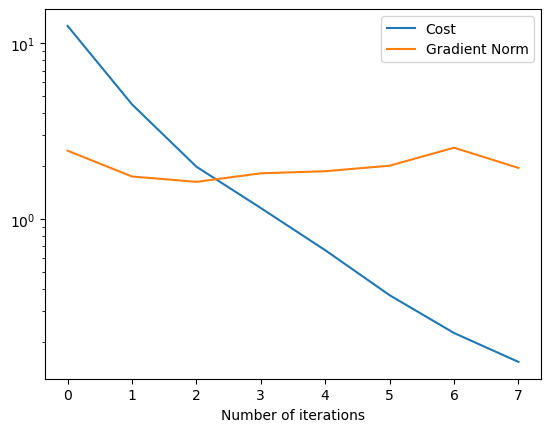

In [7]:
nb_it = len(output['cost'])

plt.semilogy(np.arange(nb_it), output['cost'], label='Cost')
plt.semilogy(np.arange(nb_it), output['gradient_norm'], label='Gradient Norm')
plt.legend()
plt.xlabel("Number of iterations")
plt.show()

In [8]:
viz.display(q0)

In [9]:
q, v = q0, np.zeros(robot.model.nv)

t = 0.0
for k in range(N):
    tic = time.time()

    tau_control = output['control'][k]
    x = dynamics(np.concat((q, v)), tau_control)
    q, v = x[:robot.model.nq], x[robot.model.nq:]

    viz.display(q)

    toc = time.time()
    ellapsed = toc - tic
    dt_sleep = max(0, dt - (ellapsed))

    time.sleep(dt_sleep)
    t += dt

In [10]:
print(f"Final q: {q}")
print(f"Target q: {target[:robot.model.nq]}")
print()
print(f"Final v: {v}")
print(f"Target v: {target[robot.model.nq:]}")
print()
print(f"Error: {np.linalg.norm(target - x):.5f}")

Final q: [ 0.23796987 -0.60411953  2.80405269  3.13652921  0.86119154 -0.95513028]
Target q: [ 0.23595929 -0.60743842  2.78143221  3.12028079  0.87114085 -0.96511552]

Final v: [ 0.05267195 -0.23456819 -0.05101985 -0.04614928 -0.00759049 -0.01164297]
Target v: [0. 0. 0. 0. 0. 0.]

Error: 0.25241
